## Mercado Libre Tech Challenge Part 4: Time Series Forecasting

### Objetive: build a model to predict daily sales 21 days in the future using historical sales data.

### Imports & Utils

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
import optuna
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from enum import Enum
from sklearn.metrics import mean_squared_log_error
import pickle
import random

TIME_COLUMNS = [
        "year",
        "month",
        "week_of_year",
        "day_of_week",
        "day_of_month",
        "day_of_year"
    ]

TARGET = "daily_sales"

BACKWARD_WINDOW_SIZE = 30  # Sales in this number of past days will be used as model feature.
FORWARD_WINDOW_SIZE = 21 # Sales will be predicted for this number of days in the future.


class ModelFeatures(list, Enum):
    RAW_TIME = [TARGET] + TIME_COLUMNS
    NORMALIZED_TIME = [TARGET] + [f"{x}_norm" for x in TIME_COLUMNS]
    CYCLIC_TIME = [TARGET] + [f"{x}_sin" for x in TIME_COLUMNS] + [f"{x}_cos" for x in TIME_COLUMNS]
    

def add_cyclic_time(df: pd.DataFrame, time_column: str) -> pd.DataFrame:
    """Adds cyclic encoding of time features to dataset

    Args:
        df (pd.DataFrame): dataset with time column to encode
        time_column (str): time column to encode

    Returns:
        pd.DataFrame: dataset with time encoded columns added.
    """

    time_max = df[time_column].max()
    df[f"{time_column}_sin"] = df[time_column].transform(
        lambda x: np.sin((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    df[f"{time_column}_cos"] = df[time_column].transform(
        lambda x: np.cos((x - 1) * 2 * np.pi / time_max).astype(np.float64)
        )
    
    return df


def add_time_features(df: pd.DataFrame, time_normalize: bool, time_cyclic: bool) -> pd.DataFrame:
    """Adds different time representations to dataset.

    Args:
        df (pd.DataFrame): dataset with time column to use as base for adding time representations
        time_normalize (bool): whether to normalize time representations
        time_cyclic (bool): whether to add cyclic time encoding

    Returns:
        pd.DataFrame: dataset with added time representations
    """
    
    df = pd.concat([df, df["DATE"].dt.isocalendar()],axis=1)
    df.rename(columns={"week": "week_of_year", "day": "day_of_week"}, inplace=True)
    
    df["day_of_month"] = df["DATE"].dt.day
    df["day_of_year"] = df["DATE"].dt.day_of_year
    df["month"] = df["DATE"].dt.month

    for time_col in TIME_COLUMNS:
        if time_cyclic:
            df = add_cyclic_time(df, time_column=time_col)
        if time_normalize:
            df[f"{time_col}_norm"] = minmax_scale(df[time_col], feature_range=(-0.5, 0.5))
                
    
    return df


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicates and outliers from dataset

    Args:
        df (pd.DataFrame): raw dataset to clean

    Returns:
        pd.DataFrame: clean dataset
    """
    
    # Clean duplicates
    num_dup = df.shape[0] - df.drop_duplicates().shape[0]
    print(f"Number of duplicate rows in dataset: {num_dup}\n")
    
    if num_dup > 0:
        print("Removing duplicates ...")
        print(f"Dataset number of rows before cleaning duplicates: {df.shape[0]}")
        df.drop_duplicates(inplace=True)
        print(f"Dataset number of rows after cleaning duplicates: {df.shape[0]}")
        
    # Drop outliers
    
    return df


def pre_process(df: pd.DataFrame, time_normalize:bool = False, time_cyclic:bool = False) -> pd.DataFrame:
    """ Pre-process a dataset to use in regression model training.

    Args:
        df (pd.DataFrame): dataset to pre-process
        time_normalize (bool, optional): whether to normalize time representations. Defaults to False.
        time_cyclic (bool, optional): whether to add cyclic time encoding. Defaults to False.

    Returns:
        pd.DataFrame: dataset ready for splitting into training/val/test sets and training.
    """

    # Format date column
    # df = df.astype({"DATE": np.datetime64})

    # Rename sales column
    df.rename(columns={"UNITS_SOLD": "daily_sales"}, inplace=True)
    
    # Add time features
    df = add_time_features(df=df, time_normalize=time_normalize, time_cyclic=time_cyclic)
    
    # Sort by date
    df.sort_values("DATE", ascending=True, inplace=True)
        
    return df


def split(df:pd.DataFrame, model_features: ModelFeatures, train_fraction: float = 0.7, val_fraction: float = 0.15) -> tuple[np.ndarray]:
    """Splits dataset into training, validation and test sets

    Args:
        df (pd.DataFrame): pre-processed dataset for splitting.
        model_features (ModelFeatures): features of the regression model.
        train_fraction (float, optional): fraction of the dataset that will be used for training. Defaults to 0.7.
        val_fraction (float, optional): fraction of the dataset that will be used for validation. 
        The remaining of the dataset wil be used for testing. Defaults to 0.15.

    Returns:
        tuple[np.ndarray]: train, validation and test data splits.
    """
    
    df_size = df.shape[0]
    
    train_split_size = np.floor(df_size * train_fraction)
    train_split_size = int(train_split_size - (train_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    val_split_size = np.floor(df_size * val_fraction)
    val_split_size = int(val_split_size - (val_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    test_split_size = df_size - (train_split_size + val_split_size)
    test_split_size = int(test_split_size - (test_split_size % (BACKWARD_WINDOW_SIZE + FORWARD_WINDOW_SIZE)))
    
    train_split_idx = train_split_size
    val_split_idx = train_split_idx + val_split_size
    test_split_idx = val_split_idx + test_split_size
    
    train_split = df[model_features].iloc[0:train_split_idx, :].values.astype("float32")
    val_split = df[model_features].iloc[train_split_idx:val_split_idx, :].values.astype("float32")
    test_split = df[model_features].iloc[val_split_idx:test_split_idx, :].values.astype("float32")
    
    print("--- Splits Summary ---")
    print(f"Model features: {model_features.value}")
    print(f"Train set shape: {train_split.shape}")
    print(f"Val set shape: {val_split.shape}")
    print(f"Test set shape: {test_split.shape}\n")
    
    return train_split, val_split, test_split


def format_batch(batch:np.ndarray, use_covariates) -> np.ndarray:
    """Formats data batches for windows-based XGBoost training.

    Args:
        batch (np.ndarray): batch to format
        use_covariates (_type_): whether to use covariates or not

    Returns:
        np.ndarray: formatted batch
    """

    if use_covariates:
        batch_f = np.concatenate((batch[:, 0],batch[-1, 1:]))
    else:
        batch_f = batch[:, 0],batch[-1, 1:]
    
    return batch_f
    
    
def generate_batches(df: pd.DataFrame, use_covariates: bool = True) -> tuple[np.ndarray]:
    """Splits the datasets into batches for windows-based XGBoost training.

    Args:
        df (pd.DataFrame): dataset to partition into batches
        use_covariates (bool, optional): whether to use covariates or not. Defaults to True.

    Returns:
        tuple[np.ndarray]: (model feature batches, target batches)
    """
    
    num_features = df.shape[1]

    end=df.shape[0]
    start=0
    next=0
    x_batches=[]
    y_batches=[]  
    counter=0
    limit=max(BACKWARD_WINDOW_SIZE,FORWARD_WINDOW_SIZE)
    while next+(limit)<end:
        next=start+BACKWARD_WINDOW_SIZE
        x_batches.append(df[start:next,:])
        y_batches.append(df[next:next+FORWARD_WINDOW_SIZE,0])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, FORWARD_WINDOW_SIZE) 
    x_batches=np.asarray(x_batches) 
    x_batches = x_batches.reshape(-1, BACKWARD_WINDOW_SIZE, num_features)
    
    # Formtat X batches
    x_batches_f = []
    for batch in x_batches:
        x_batches_f.append(format_batch(batch=batch, use_covariates=use_covariates))
    x_batches_f = np.asarray(x_batches_f)
    x_batches_f = x_batches_f.reshape(-1, BACKWARD_WINDOW_SIZE + num_features - 1)
    
    # Shuffle batches
    random.seed(123)
    random.shuffle(x_batches_f)
    random.seed(123)
    random.shuffle(y_batches)
    
    print("--- Batches Summary ---")
    print("Input batches (X):")
    print(f"  Number of batches: {x_batches_f.shape[0]}")
    print(f"  Batch size: {x_batches_f.shape[1]}")
    print(f"  X batch composition: target: {BACKWARD_WINDOW_SIZE} | covariates: {num_features - 1}")
    print("Target batches (Y):")
    print(f"  Number of batches: {y_batches.shape[0]}")
    print(f"  Batch size: {y_batches.shape[1]}")
    print(f"  Y batch composition: target: {FORWARD_WINDOW_SIZE}\n")
   
   
    return x_batches_f, y_batches


def objective(trial, X_train, Y_train, X_val, Y_val, general_params):
    """Optuna function for multi-output XGBoost model hyperparamter tunning.

    Args:
        trial (_type_): hyperparam search step
        X_train (_type_): train set features
        Y_train (_type_): train set target
        X_val (_type_): validation set features
        Y_val (_type_): validation set target
        general_params (_type_): general XGBoost parameters

    Returns:
        _type_: _description_
    """
            
    param = general_params | {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "random_state": trial.suggest_categorical("random_state", [123]),
        "max_depth": trial.suggest_categorical("max_depth", [5, 7, 9, 11, 13, 15, 17, 20]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.005, 0.01, 0.013, 0.017, 0.02]),
        "subsample": trial.suggest_categorical("subsample", [0.7, 0.8, 0.9, 1.0]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0),
        "gamma": trial.suggest_float("gamma", 1e-4, 1e-2),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "colsample_bynode": trial.suggest_categorical("colsample_bynode", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "colsample_bylevel": trial.suggest_categorical("colsample_bylevel", [0.2, 0.4, 0.6, 0.8, 1.0]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
        "tweedie_variance_power": trial.suggest_categorical("tweedie_variance_power", [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.9]),
        }
    
    regressor = xgb.XGBRegressor(**param)
    
    model = MultiOutputRegressor(regressor)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "rmse")
    
    model.fit(X_train, Y_train)
    
    preds = model.predict(X_val)
    
    rmsle = mean_squared_log_error(Y_val, np.abs(preds))
    
    return rmsle
    

/home/ldarre/Documents/Train/mercado_libre/Solutions/ml_tech_challenge/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load data

In [2]:
data_path = "../data"
data_file_name = "series.csv"
data_raw = pd.read_csv(f"{data_path}/{data_file_name}")

print("Dataset info:")
print(f"{data_raw.info()}\n")

print("Dataset sample:")
display(data_raw.sample(10, random_state=152))

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB
None

Dataset sample:


,CATEGORY,DATE,UNITS_SOLD
136,CATEG-3,2021-05-07,2559
452,CATEG-3,2021-08-14,2085
181,CATEG-1,2021-03-05,77
528,CATEG-2,2021-06-06,42
2477,CATEG-2,2020-12-14,24
1951,CATEG-2,2021-08-23,28
316,CATEG-2,2020-02-17,7
2285,CATEG-3,2020-04-17,861
1383,CATEG-3,2021-01-28,2136
179,CATEG-2,2020-11-06,4


#### Dataset relevant features

##### Sales time series

<AxesSubplot: xlabel='DATE'>

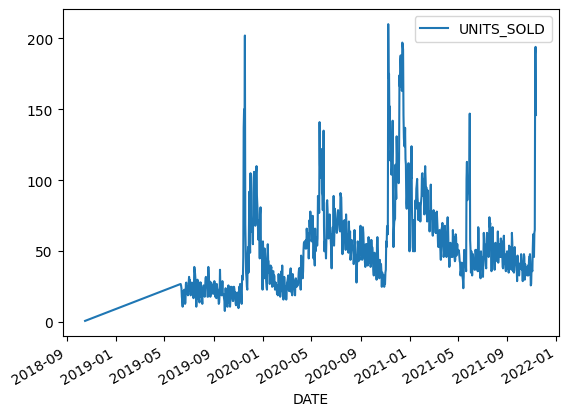

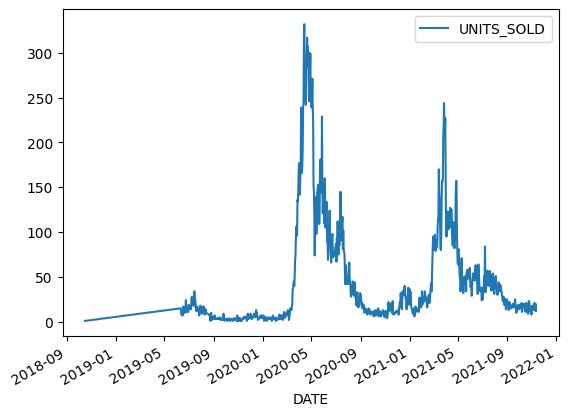

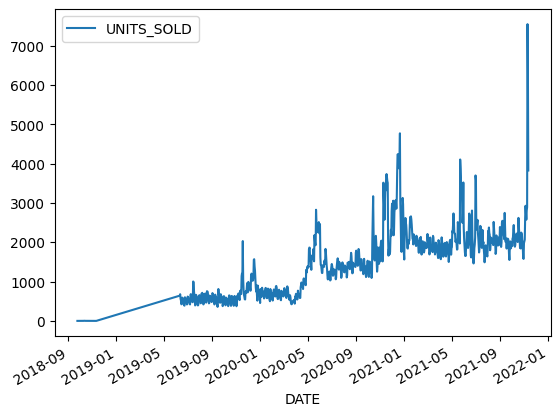

In [3]:
data_raw = data_raw.astype({"DATE": np.datetime64})
data_raw.loc[data_raw["CATEGORY"] == "CATEG-1"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-2"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-3"].plot(x="DATE", y="UNITS_SOLD")

<AxesSubplot: xlabel='DATE'>

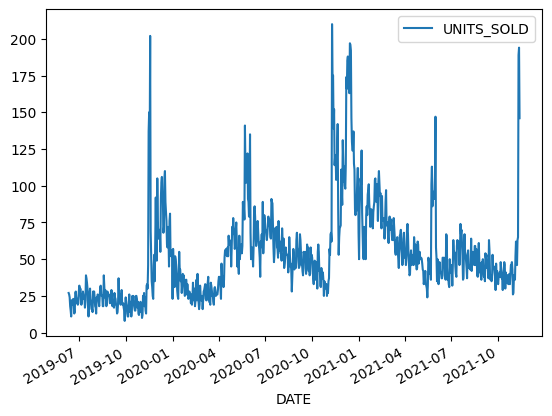

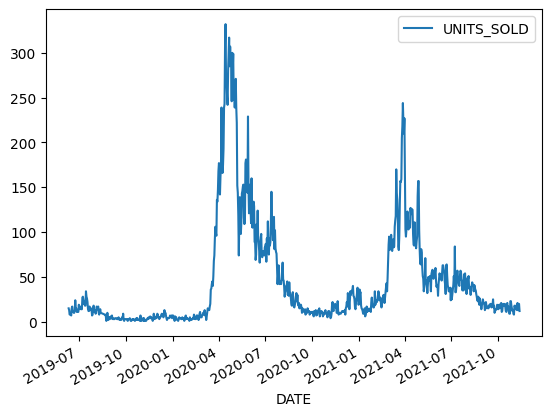

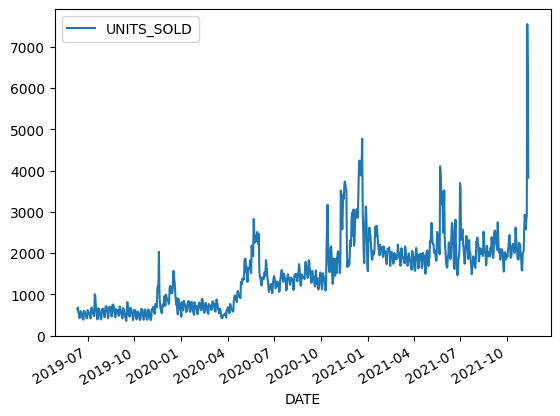

In [4]:
data_raw = data_raw.loc[data_raw["DATE"].dt.year >= 2019]

data_raw.loc[data_raw["CATEGORY"] == "CATEG-1"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-2"].plot(x="DATE", y="UNITS_SOLD")
data_raw.loc[data_raw["CATEGORY"] == "CATEG-3"].plot(x="DATE", y="UNITS_SOLD")

##### Sales distribution

In [5]:
data_raw[["CATEGORY", "UNITS_SOLD"]].groupby("CATEGORY").describe()

UNITS_SOLD                                                          \
              count         mean         std    min    25%     50%      75%   
CATEGORY                                                                      
CATEG-1       886.0    53.189616   31.891344    8.0   31.0    47.0    65.00   
CATEG-2       878.0    44.797267   59.482929    1.0    9.0    19.0    51.75   
CATEG-3       886.0  1513.197517  837.073072  357.0  708.0  1505.5  2022.00   

                  
             max  
CATEGORY          
CATEG-1    210.0  
CATEG-2    332.0  
CATEG-3   7551.0

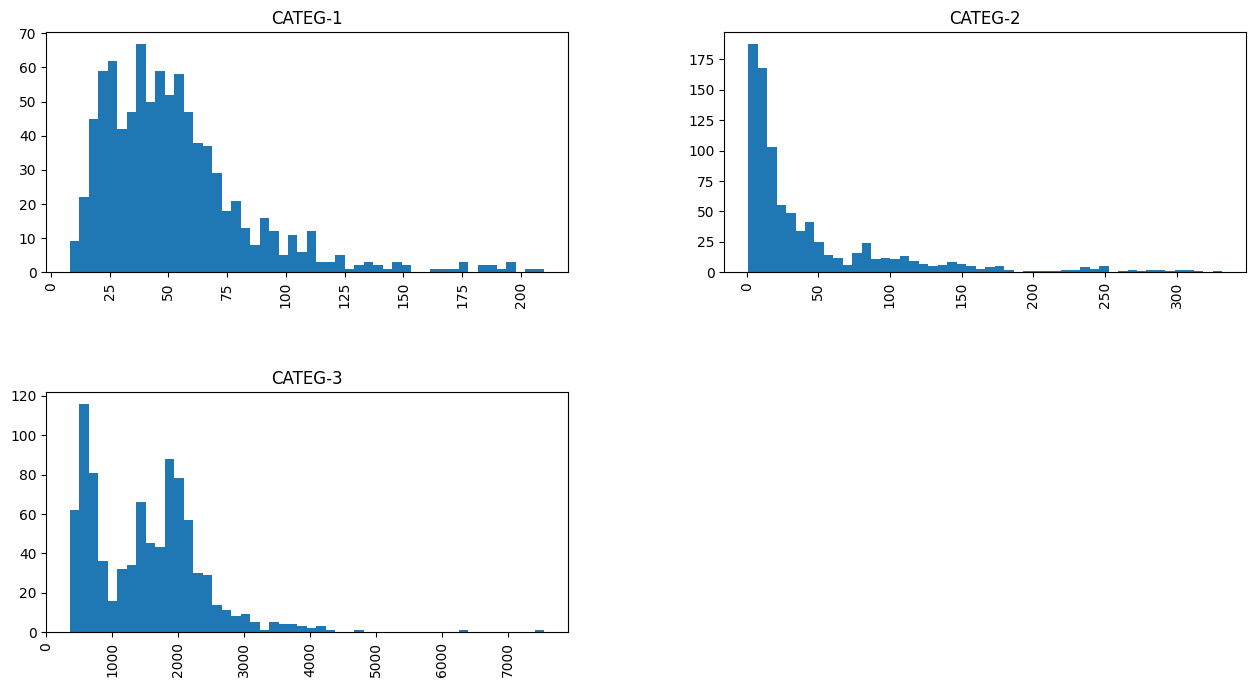

In [6]:
h = data_raw[["CATEGORY", "UNITS_SOLD"]].hist(by="CATEGORY", figsize=(15,8), bins=50)

##### Observations

Although daily sales data is available, for the three categories of products, since Sept/Oct 2018, there is a big jump between that period of 2018 and June 2019. Consequently, only data after June 2019 should be considered.

All three categories have similar number of datapoints. Thus, differences in model quality should not emerge between categories due to data availability.

The following daily sales distributions characteristics can be observed:
- **Range of values**: categories 1 and 2 range from 0 to 200-300 sales per day, while categoy 1 ranges from 0 to >4000. Segmenting products in terms of volume sales and training volume-segment specific models is a good idea to improve model quality, avoiding a single model trying to predict wildly different sales values. An alternative here could be to target encode the categorical varible `CATEGORY` using as target encoding feature the daily sales, however, that adds extra complexity to the model. In the present case, for time reasons, only volume segment specific models will be trained, but it would be desirable to also train a single model using target encoding for comparison reasons.

- **Distribution**: while categories 1 and 2 show a mean peak accompanied by a right tail of different strenght (more important for category 2), category 3 shows two important peaks, one below and the other above 1000 sales. As revealed by the time series, values below 1000 occurred before April/May 2020, while a notable increase is observed after that date. This is an indication of a change in the market for this category, and hints on the need to treat/model the behaviour of category 3 taking that into consideration. In this context, it would be a good idea to use data after the mentioned change in the market, however, that means a too aggressive reduction in the amount of data available for training. To achieve a compromise between avoiding the mixture of two dissimilar market states and having enought data points for modelling, in the present work, data before 2020 will not be used for category 3.

- **Long right tails**: although sales distributions of categories 1 and 3 show a certain degree of right tails, those are not *heavy tails*, which is evidenced by the similarity between their means and medians (see table above). However, in the case of category 2 a *heavy right tail* is observed, highlighted by the difference between the mean (~45) and the median (~19). In this context, using a tweedie regression could help improving model quality. Nevertheess, it might be reasonable to expect somewhat poorer predictions for category 2, compared to categories 1 and 3. To further improve modelling of category 2, it might be interesting to try to segment the associated products in terms of sales volume and train specific models. 




### Modelling approach

Herein the following modelling approach will be used to predict daily sales in a future time window of 21 days:
- Three models, one per category will be trained
- Each model will be based on Tweedie regression using the XGBoost method in the Multiple-Output format that allows multiple regressors, one for each day of the future time window (21 regressors). 
- To alleviate the problem of having multiple **independent** regressors, the window-based approach of [Elsayed et al (2021)](https://arxiv.org/pdf/2101.02118.pdf) will be used. In particular, the version including covariates will be employed, as the corresponding data is available in the dataset, and such an approach results in the best option compared with state of the art methods, as described in the article.
- The date (in different representations) will be used as covariate in the regression, testing different ways to scale/encode time (raw, normalization, cyclic time).
- The dataset will be splitted by category and into training, validation and test sets. Models will be trained searching for optimal hyperparameters using the Tree-structured Parzen Estimator method (a form of bayesian optimization) on the validation set, and finally retraining the model with the best hyperparameters found, combinig the training and validation sets, and testing on the test set.

### Dataset pre-processing

In [7]:
# Data cleanup and pre-processing
data_clean = clean_up(df=data_raw)
data = pre_process(df=data_clean, time_normalize=True, time_cyclic=True)

# Split by category
training_data = {
    "CATEG-1": {
        "data": data.loc[data["CATEGORY"] == "CATEG-1"],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    },
    "CATEG-2": {
        "data": data.loc[data["CATEGORY"] == "CATEG-2"],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    },
    "CATEG-3": {
        "data": data.loc[
            (data["CATEGORY"] == "CATEG-3")
            & (data["year"] >= 2020)
            ],
        "train_set": {"X": None, "Y": None},
        "val_set": {"X": None, "Y": None},
        "test_set": {"X": None, "Y": None},
        "hypersearch_data": None,
        "model": None,
    }
}

for c in training_data.keys():
    print(f" ----- Generating datasets for category {c} ----- ")
    train_set, val_set, test_set = split(df=training_data[c]["data"], model_features=ModelFeatures.NORMALIZED_TIME, train_fraction=0.7, val_fraction=0.2)
    print("Training set batches:")
    training_data[c]["train_set"]["X"], training_data[c]["train_set"]["Y"]  = generate_batches(df=train_set)
    print("Validation set batches:")
    training_data[c]["val_set"]["X"], training_data[c]["val_set"]["Y"]  = generate_batches(df=val_set)
    print("Test set batches:")
    training_data[c]["test_set"]["X"], training_data[c]["test_set"]["Y"]  = generate_batches(df=test_set)
    

Number of duplicate rows in dataset: 0

 ----- Generating datasets for category CATEG-1 ----- 
--- Splits Summary ---
Model features: ['daily_sales', 'year_norm', 'month_norm', 'week_of_year_norm', 'day_of_week_norm', 'day_of_month_norm', 'day_of_year_norm']
Train set shape: (612, 7)
Val set shape: (153, 7)
Test set shape: (102, 7)

Training set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 553
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Target batches (Y):
  Number of batches: 553
  Batch size: 21
  Y batch composition: target: 21

Validation set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 94
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Target batches (Y):
  Number of batches: 94
  Batch size: 21
  Y batch composition: target: 21

Test set batches:
--- Batches Summary ---
Input batches (X):
  Number of batches: 43
  Batch size: 36
  X batch composition: target: 30 | covariates: 6
Targe

### Model training

In [8]:
for c in training_data.keys():
    print(f"Training model for category {c} ...")
    
    # Hyper-parameter optimization
    general_params = {
        "n_jobs": -1,
        "tree_method":"hist",
        "objective": "reg:tweedie",
        # "objective": "reg:squarederror",
        "booster": "gbtree",
    }

    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(), 
        direction='minimize', 
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        )

    study.optimize( 
        lambda trial: objective(
            trial=trial, 
            X_train=training_data[c]["train_set"]["X"], 
            Y_train=training_data[c]["train_set"]["Y"], 
            X_val=training_data[c]["val_set"]["X"], 
            Y_val=training_data[c]["val_set"]["Y"],
            general_params=general_params),
        n_trials=30, 
        gc_after_trial=True)

    print(f"Best RMSLE: {study.best_trial.value}")
    print(f"Best trial: {study.best_trial.params}")
    
    training_data[c]["hypersearch_data"] = study
    
    best_xgbparams = general_params | study.best_params 
    print(f"Best parameters: {best_xgbparams}")
    
    # Train model using best hyper-parameters
    model = xgb.XGBRegressor(**best_xgbparams)
    multioutput=MultiOutputRegressor(model).fit(
        np.concatenate([
            training_data[c]["train_set"]["X"], 
            training_data[c]["val_set"]["X"]
            ]),
        np.concatenate([
            training_data[c]["train_set"]["Y"], 
            training_data[c]["val_set"]["Y"]
            ])
        )
    training_data[c]["model"] = multioutput
    
    

[I 2022-11-14 08:07:14,427] A new study created in memory with name: no-name-7b64604c-145d-48ea-9019-56d883b42933


Training model for category CATEG-1 ...


[I 2022-11-14 08:07:18,308] Trial 0 finished with value: 0.05309770628809929 and parameters: {'n_estimators': 140, 'random_state': 123, 'max_depth': 20, 'learning_rate': 0.02, 'subsample': 0.9, 'reg_alpha': 5.62346742493007, 'reg_lambda': 7.990312527745703, 'gamma': 0.0032947188815507338, 'colsample_bytree': 0.4, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 268, 'tweedie_variance_power': 1.1}. Best is trial 0 with value: 0.05309770628809929.
[I 2022-11-14 08:07:21,588] Trial 1 finished with value: 0.07419998198747635 and parameters: {'n_estimators': 148, 'random_state': 123, 'max_depth': 15, 'learning_rate': 0.02, 'subsample': 0.9, 'reg_alpha': 5.055245962967562, 'reg_lambda': 8.180332930260269, 'gamma': 0.004526724350284621, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 1.0, 'min_child_weight': 63, 'tweedie_variance_power': 1.3}. Best is trial 0 with value: 0.05309770628809929.
[I 2022-11-14 08:07:22,429] Trial 2 finished with value: 

Best RMSLE: 0.050552017986774445
Best trial: {'n_estimators': 146, 'random_state': 123, 'max_depth': 15, 'learning_rate': 0.02, 'subsample': 0.8, 'reg_alpha': 5.063301187905626, 'reg_lambda': 9.136039286962106, 'gamma': 0.00450372167794527, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 49, 'tweedie_variance_power': 1.1}
Best parameters: {'n_jobs': -1, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'booster': 'gbtree', 'n_estimators': 146, 'random_state': 123, 'max_depth': 15, 'learning_rate': 0.02, 'subsample': 0.8, 'reg_alpha': 5.063301187905626, 'reg_lambda': 9.136039286962106, 'gamma': 0.00450372167794527, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 49, 'tweedie_variance_power': 1.1}


[I 2022-11-14 08:09:11,779] A new study created in memory with name: no-name-d2209b7f-9bd6-472f-b084-8e302c462bed


Training model for category CATEG-2 ...


[I 2022-11-14 08:09:13,960] Trial 0 finished with value: 10.297053337097168 and parameters: {'n_estimators': 96, 'random_state': 123, 'max_depth': 11, 'learning_rate': 0.013, 'subsample': 0.7, 'reg_alpha': 6.849961613121241, 'reg_lambda': 4.9695892576364935, 'gamma': 0.00891708275051808, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 255, 'tweedie_variance_power': 1.7}. Best is trial 0 with value: 10.297053337097168.
[I 2022-11-14 08:09:17,205] Trial 1 finished with value: 0.2715733051300049 and parameters: {'n_estimators': 166, 'random_state': 123, 'max_depth': 9, 'learning_rate': 0.013, 'subsample': 0.7, 'reg_alpha': 9.87145859278647, 'reg_lambda': 3.4380458740675746, 'gamma': 0.006711184128226923, 'colsample_bytree': 0.4, 'colsample_bynode': 0.6, 'colsample_bylevel': 1.0, 'min_child_weight': 114, 'tweedie_variance_power': 1.0}. Best is trial 1 with value: 0.2715733051300049.
[I 2022-11-14 08:09:19,255] Trial 2 finished with value: 9.0

Best RMSLE: 0.1517402082681656
Best trial: {'n_estimators': 199, 'random_state': 123, 'max_depth': 13, 'learning_rate': 0.013, 'subsample': 0.9, 'reg_alpha': 2.9489786047294606, 'reg_lambda': 0.06611651894953352, 'gamma': 0.005160634545346491, 'colsample_bytree': 0.4, 'colsample_bynode': 0.8, 'colsample_bylevel': 1.0, 'min_child_weight': 176, 'tweedie_variance_power': 1.3}
Best parameters: {'n_jobs': -1, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'booster': 'gbtree', 'n_estimators': 199, 'random_state': 123, 'max_depth': 13, 'learning_rate': 0.013, 'subsample': 0.9, 'reg_alpha': 2.9489786047294606, 'reg_lambda': 0.06611651894953352, 'gamma': 0.005160634545346491, 'colsample_bytree': 0.4, 'colsample_bynode': 0.8, 'colsample_bylevel': 1.0, 'min_child_weight': 176, 'tweedie_variance_power': 1.3}


[I 2022-11-14 08:11:30,550] A new study created in memory with name: no-name-592304f5-0a64-4ac5-8ea5-eb6ff9290f7c


Training model for category CATEG-3 ...


[I 2022-11-14 08:11:32,668] Trial 0 finished with value: 13.974190711975098 and parameters: {'n_estimators': 141, 'random_state': 123, 'max_depth': 5, 'learning_rate': 0.017, 'subsample': 0.8, 'reg_alpha': 2.890447881096442, 'reg_lambda': 7.670011733307207, 'gamma': 0.006156491788083922, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'colsample_bylevel': 0.6, 'min_child_weight': 146, 'tweedie_variance_power': 1.5}. Best is trial 0 with value: 13.974190711975098.
[I 2022-11-14 08:11:37,343] Trial 1 finished with value: 7.281416893005371 and parameters: {'n_estimators': 141, 'random_state': 123, 'max_depth': 20, 'learning_rate': 0.013, 'subsample': 0.8, 'reg_alpha': 6.745854644531149, 'reg_lambda': 1.1332852115610008, 'gamma': 0.0035101700102207114, 'colsample_bytree': 0.2, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.8, 'min_child_weight': 206, 'tweedie_variance_power': 1.3}. Best is trial 1 with value: 7.281416893005371.
[I 2022-11-14 08:11:42,138] Trial 2 finished with value: 4.

Best RMSLE: 0.19719041883945465
Best trial: {'n_estimators': 179, 'random_state': 123, 'max_depth': 17, 'learning_rate': 0.02, 'subsample': 0.7, 'reg_alpha': 8.499013884705843, 'reg_lambda': 5.580397948898994, 'gamma': 0.007726379830065215, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 4, 'tweedie_variance_power': 1.1}
Best parameters: {'n_jobs': -1, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'booster': 'gbtree', 'n_estimators': 179, 'random_state': 123, 'max_depth': 17, 'learning_rate': 0.02, 'subsample': 0.7, 'reg_alpha': 8.499013884705843, 'reg_lambda': 5.580397948898994, 'gamma': 0.007726379830065215, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.2, 'min_child_weight': 4, 'tweedie_variance_power': 1.1}


In [19]:
# Store trained models
with open("models/category_1_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-1"]["model"], ph)
    
with open("models/category_2_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-2"]["model"], ph)
    
with open("models/category_3_models.pkl", "wb") as ph: 
    pickle.dump(training_data["CATEG-3"]["model"], ph)
    
with open("models/training_data.pkl", "wb") as ph: 
    pickle.dump(training_data, ph)

### Evaluate

--- Metrics for model: CATEG-1 ---
MAE: 5.419291019439697
MAPE: 0.11856211721897125
RMSE: 6.786903381347656
---Prediction example: ---


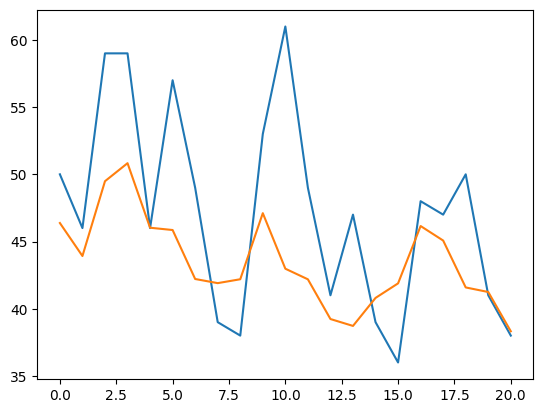

--- Metrics for model: CATEG-2 ---
MAE: 6.2646918296813965
MAPE: 0.3341309130191803
RMSE: 7.1178693771362305
---Prediction example: ---


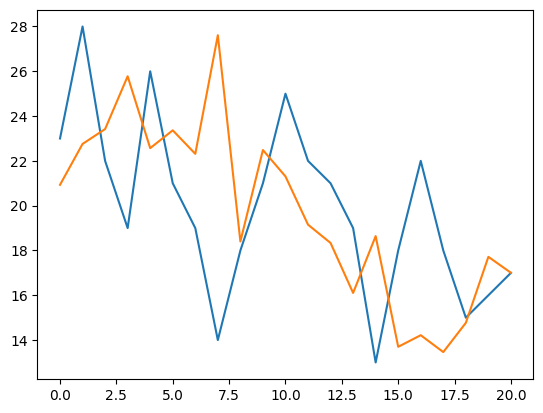

--- Metrics for model: CATEG-3 ---
MAE: 222.21331787109375
MAPE: 0.10188902914524078
RMSE: 288.8894958496094
---Prediction example: ---


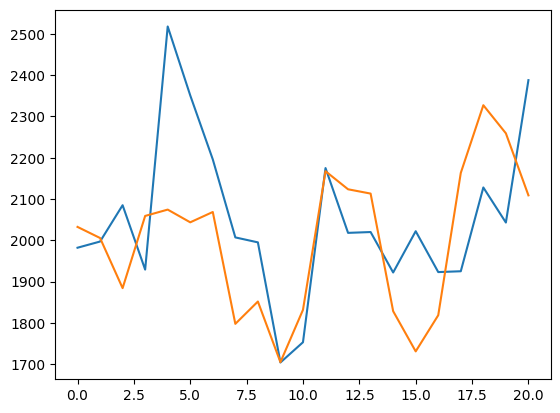

In [18]:
for c in training_data.keys():
    print(f"--- Metrics for model: {c} ---")
    
    x_batches_test = training_data[c]["test_set"]["X"]
    y_batches_test = training_data[c]["test_set"]["Y"]
    prediction=training_data[c]["model"].predict(x_batches_test)
    
    RMSE=np.sqrt(np.mean(np.power((prediction - y_batches_test),2)))
    MAE=np.mean(np.abs((prediction - y_batches_test)))
    MAPE=np.mean((np.abs(prediction - y_batches_test) / np.abs(y_batches_test)))

    print(f"MAE: {MAE}") 
    print(f"MAPE: {MAPE}")   
    print(f"RMSE: {RMSE}")
    
    print("---Prediction example: ---")
    plt.plot(y_batches_test[0])
    plt.plot(prediction[0])
    plt.show()
    

### Final Remarks

- Regression models for each product category were trained and tested obtaining models of different quality. Reasonably well performing models are obtained for categories 1 an 3 (MAPE values of 12% and 10%, respectively), while, in agreement with expectations mentioned in the *Long right tails* section of the *Observations* above, the model obtained for category 2 shows poorer performance (MAPE of 33%).
- The main difficulty in modelling category 2 resides in the very high peak of sales observed (see *Sales time series* plots above) around April 2020, which produces the mentioned heavy right tail. Comparing this peak to that occurring around the same dates of 2021, indicates a similar structure between the two, but the one in 2020 has an additional higher earlier sub-peak. The latter seems to be an outlier behaviour of the market at that time, producing a spike that disriupts sales patterns.
- Based on the previous point, an improvement for modelling category 2 could be achieved by excluding the time period of the mentioned sales spike (month of April of 2020). For time reasons this was not tested in the present work, but should be the immediate next step to take.
- Preliminary tests (not included in this work) indicate that time features normalization is the best approach compared with raw values or cyclic encoding.
- The hyper-parameter search performend in the present work was rather limited for time reasons, but should be extended.
- Although the chosen approach (window-based multioutput XGBoost) has been shown to produce state of the art results (see article mentioned above) it would be good to test additional models like Temporal Regularized Matrix Factorization (TRMF) or Temporal Fusion Transformers (TFTs).